# Import Libraries

In [4]:
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, RNN, LSTMCell, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal, RandomUniform, GlorotNormal

SEED = 42

In [2]:
lstm_cell_units = 32
baseline_decay = 0.999
opt = Adam(lr=0.00035, decay=1e-3, amsgrad=True)
controller_batch_size = 32
controller_epochs = 5

input_x = np.array([[[SEED,SEED,SEED,SEED]]])

/home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [5]:
controller_input = Input(shape=(1,4,))        

cell = LSTMCell(
    lstm_cell_units,
    kernel_initializer=RandomUniform(minval=-0.1, maxval=0.1),
    recurrent_initializer=RandomUniform(minval=-0.1, maxval=0.1))

x = RNN(cell, return_state=True)(controller_input)
y = Dense(4)(x[0])
y = Activation(activation="softmax")(y)

controller_rnn = Model(inputs=controller_input, outputs=y)

2022-04-25 23:08:17.509576: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-25 23:08:17.602088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 23:08:17.602466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-25 23:08:17.602482: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-25 23:08:17.625308: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-25 23:08:17.625357: I tensorflow/stream_execut

In [12]:
baseline = None

def __controller_loss(y_true, y_pred):
    if baseline is None:
        #print('baseline is None')
        baseline = 0
    else:
        #print('baseline is not None')
        baseline -= (1 - baseline_decay) * (baseline - reward)

    #print(f' ..baseline: {self.baseline} | baseline_decay: {self.baseline_decay} | reward: {self.reward}')
    #tf.print(f' ..y_pred: ', y_pred)
    l = y_pred * (reward - baseline)
    #tf.print(f' ..loss: ', l)
    return l

controller_rnn.compile(loss=__controller_loss, optimizer=opt)

In [13]:
targets = np.array([[[0.23,0.34,0.23,0.23]]])

controller_rnn.fit(
            input_x,
            targets,
            epochs=controller_epochs,
            batch_size=controller_batch_size,
            verbose=0)

UnboundLocalError: in user code:

    /home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_114638/1370256758.py:4 __controller_loss  *
        if baseline is None:
    /home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/autograph/operators/variables.py:25 ld
        return v.read()
    /home/guilherme/anaconda3/envs/mteval-icao-reqs/submodules/icao_nets_training/lib/python3.8/site-packages/tensorflow/python/autograph/operators/variables.py:87 read
        raise UnboundLocalError("'{}' is used before assignment".format(

    UnboundLocalError: 'baseline' is used before assignment


# Test Controller RNN - LSTM

In [ ]:
import sys
import random

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Embedding, LSTM, LSTMCell, RNN, Reshape
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses, metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomUniform, HeNormal, GlorotNormal

import tensorflow as tf


def get_weight_initializer(initializer=None, seed=None):
    if initializer is None:
        return HeNormal()
    elif initializer == "lstm":
        return RandomUniform(minval=-0.1, maxval=0.1)
    else:
        return GlorotNormal()


def get_weight_regularizer(regularizer=None, rate=1e-4):
    if regularizer is None:
        return regularizers.l2(rate)
    else:
        return regularizer(rate)


class ControllerRNNController(object):
    def __init__(self,
                 controller_network_name,
                 num_nodes,
                 num_opers,
                 input_x,
                 reward=0,
                 temperature=5.0,
                 tanh_constant=2.5,
                 model_file=None,
                 lstm_cell_units=32,
                 baseline_decay=0.999,
                 opt=Adam(learning_rate=0.00035, decay=1e-3, amsgrad=True)):

        self.controller_network_name = controller_network_name
        self.num_nodes = num_nodes
        self.num_opers = num_opers
        self.reward = reward
        self.input_x = input_x
        self.temperature = temperature
        self.tanh_constant = tanh_constant
        self.lstm_cell_units = lstm_cell_units
        self.opt = opt
        self.model_file = model_file

        self.controller_rnn = self.generate_controller_rnn()
        self.baseline = None
        self.baseline_decay = baseline_decay

        #self.graph = tf.get_default_graph()

    def lstm_reshape(self,
                     inputs,
                     name_prefix,
                     index,
                     reshaped_inputs=None,
                     initial=False):
        name_prefix = "{0}_{1}_{2}".format(self.controller_network_name,
                                           name_prefix, index)
        cell = LSTMCell(
            self.lstm_cell_units,
            kernel_initializer=get_weight_initializer(initializer="lstm"),
            recurrent_initializer=get_weight_initializer(initializer="lstm"))
        if initial:
            x = RNN(
                cell,
                return_state=True,
                name="{0}_{1}".format(name_prefix, "lstm"))(inputs)
        else:
            x = RNN(
                cell,
                return_state=True,
                name="{0}_{1}".format(name_prefix, "lstm"))(
                    reshaped_inputs, initial_state=inputs[1:])
        rx = Reshape(
            (-1, self.lstm_cell_units),
            name="{0}_{1}".format(name_prefix, "reshape"))(x[0])
        return x, rx

    def dense_softmax(self, inputs, num_classes, name_prefix, index):
        name_prefix = "{0}_{1}_{2}".format(self.controller_network_name,
                                           name_prefix, index)
        y = Dense(
            num_classes, name="{0}_{1}".format(name_prefix, "dense"))(inputs)
        y = Activation(
            activation="softmax",
            name="{0}_{1}".format(name_prefix, "softmax"))(y)
        return y

    def generate_controller_rnn(self):
        outputs = []
        controller_input = Input(shape=(1, 1,), name="{0}_{1}".format(self.controller_network_name, "input"))

        for i in range(2, self.num_nodes):
            for o in ["inputL", "inputR", "operL", "operR"]:
                if i == 2 and o == "inputL":
                    _x, _rx, _initial = controller_input, None, True
                else:
                    _x, _rx, _initial = x, rx, False

                if o in ["inputL", "inputR"]:
                    _num_classes = i
                else:
                    _num_classes = self.num_opers

                x, rx = self.lstm_reshape(
                    inputs=_x,
                    name_prefix=o,
                    index=i,
                    reshaped_inputs=_rx,
                    initial=_initial)
                y = self.dense_softmax(
                    inputs=x[0],
                    num_classes=_num_classes,
                    name_prefix=o,
                    index=i)
                outputs.append(y)

        controller_rnn = Model(inputs=controller_input, outputs=outputs)

        if self.model_file is not None and os.path.exists(self.model_file):
            controller_rnn.load_weights(self.model_file)
        return controller_rnn

    def compile_controller_rnn(self):
        def _controller_loss(y_true, y_pred):
            if self.baseline is None:
                self.baseline = 0
            else:
                self.baseline -= (1 - self.baseline_decay) * (self.baseline - self.reward)
            return y_pred * (self.reward - self.baseline)

        def _define_loss(controller_loss):
            outputs_loss = {}
            for i in range(2, self.num_nodes):
                outputs_loss["{0}_{1}_{2}_{3}".format(self.controller_network_name, "inputL", i, "softmax")] = controller_loss
                outputs_loss["{0}_{1}_{2}_{3}".format(self.controller_network_name, "inputR", i, "softmax")] = controller_loss
                outputs_loss["{0}_{1}_{2}_{3}".format(self.controller_network_name, "operL", i, "softmax")] = controller_loss
                outputs_loss["{0}_{1}_{2}_{3}".format(self.controller_network_name, "operR", i, "softmax")] = controller_loss
            return outputs_loss

        self.controller_rnn.compile(loss=_define_loss(_controller_loss), optimizer=self.opt)

    def save_model(self):
        self.controller_rnn.save_weights(self.model_file)

    def train_controller_rnn(self,
                             targets,
                             batch_size=1,
                             epochs=50,
                             callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')]):
        #with self.graph.as_default():
        self.compile_controller_rnn()
        self.controller_rnn.fit(
            self.input_x,
            targets,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0)

    def softmax_predict(self):
        #with self.graph.as_default():
        self.compile_controller_rnn()
        return self.controller_rnn.predict(self.input_x)

    def random_sample_softmax(self, controller_pred):
        sample_softmax = []
        for cp in controller_pred:
            cp /= self.temperature
            cp = self.tanh_constant * np.tanh(cp)
            cp = np.exp(cp) / np.sum(np.exp(cp))
            cp = np.array([np.random.multinomial(1, cp[0])])
            sample_softmax.append(cp)
        return sample_softmax

    def convert_pred_to_cell(self, controller_pred):
        cell_pred = {}
        for p in range(2, self.num_nodes):
            pos = list(range((p - 2) * 4, ((p - 2) * 4) + 4))
            cell_pred[p] = {
                "L": {
                    "input_layer": np.argmax(controller_pred[pos[0]]),
                    "oper_id": np.argmax(controller_pred[pos[2]])
                },
                "R": {
                    "input_layer": np.argmax(controller_pred[pos[1]]),
                    "oper_id": np.argmax(controller_pred[pos[3]])
                }
            }
        return cell_pred

    def convert_pred_to_ydict(self, controller_pred):
        ydict = {}
        name_prefix = self.controller_network_name
        for i in range(2, self.num_nodes):
            pos = list(range((i - 2) * 4, ((i - 2) * 4) + 4))
            ydict["{0}_{1}_{2}_{3}".format(name_prefix, "inputL", i, "softmax")] = controller_pred[pos[0]]
            ydict["{0}_{1}_{2}_{3}".format(name_prefix, "inputR", i, "softmax")] = controller_pred[pos[1]]
            ydict["{0}_{1}_{2}_{3}".format(name_prefix, "operL", i, "softmax")] = controller_pred[pos[2]]
            ydict["{0}_{1}_{2}_{3}".format(name_prefix, "operR", i, "softmax")] = controller_pred[pos[3]]
        return ydict


In [ ]:
contr = ControllerRNNController("netname", num_nodes=3, num_opers=3, input_x=X)

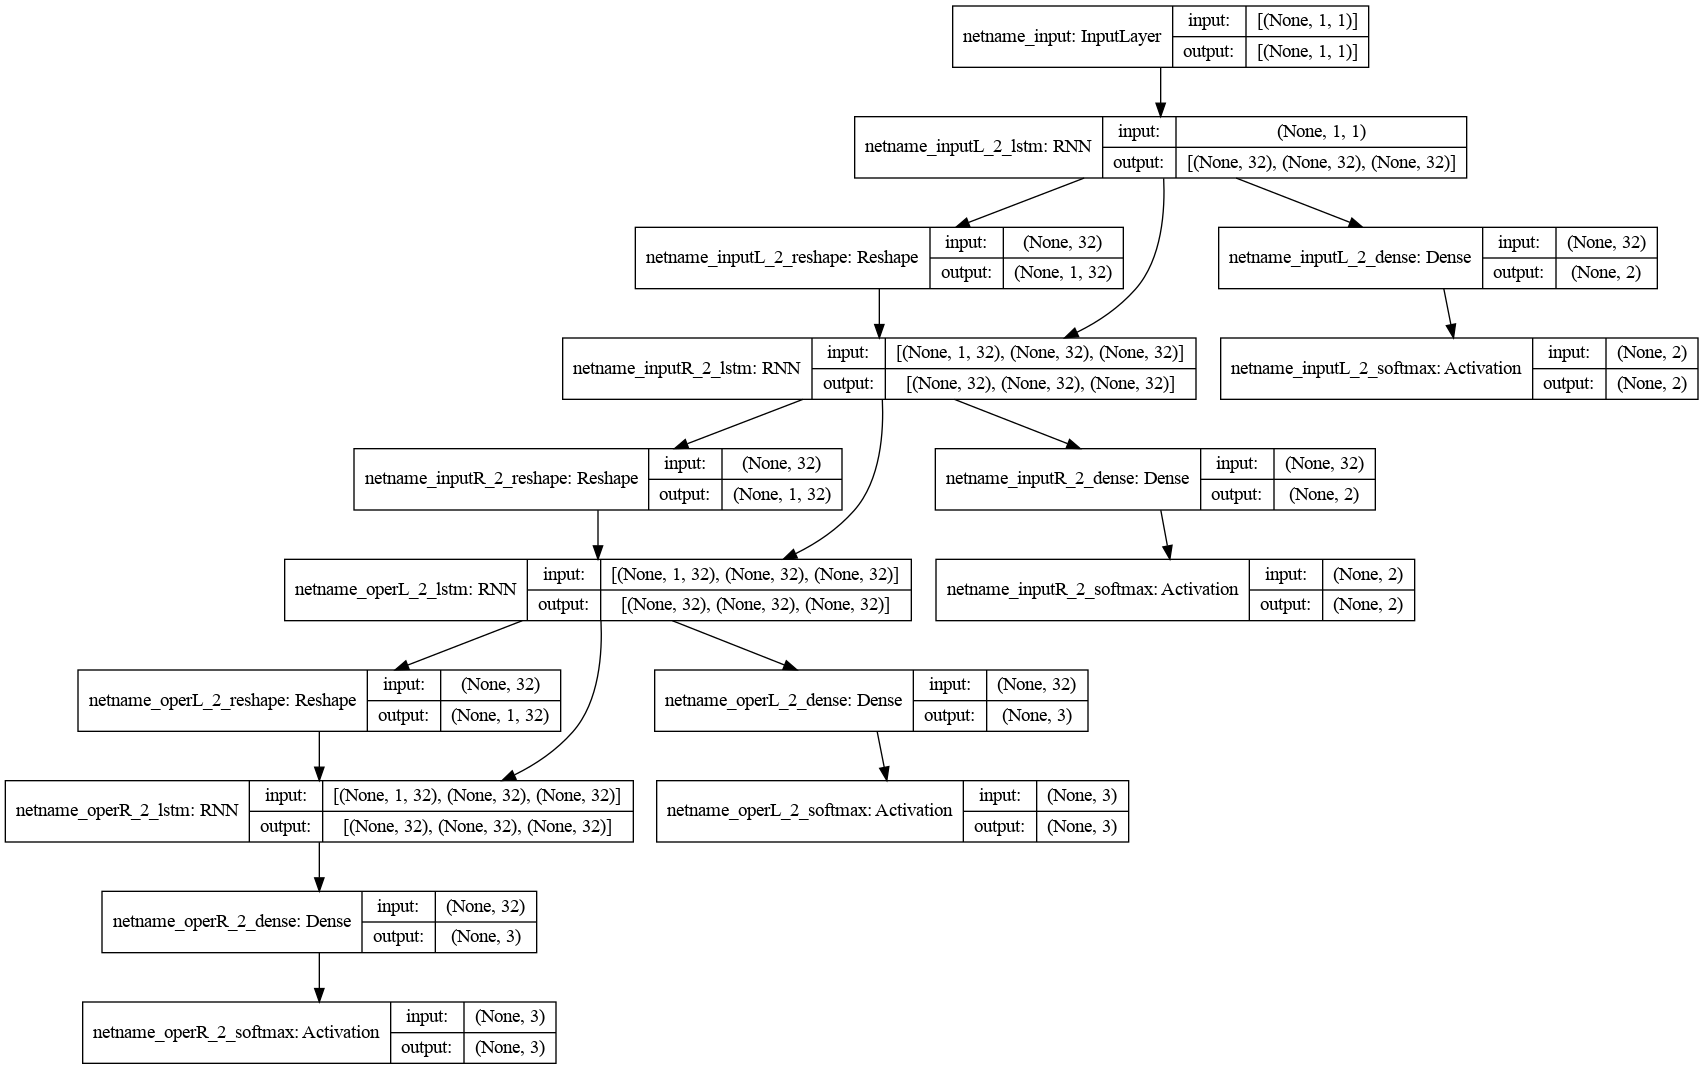

In [23]:
from tensorflow.keras.utils import plot_model

#contr.controller_rnn.summary()
plot_model(contr.controller_rnn, expand_nested=True, show_shapes=True)

# Test Simple LSTM

In [24]:
import tensorflow as tf

import os
# disable tensorflow log level infos
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # show only errors

inputs = tf.random.normal([32, 10, 8])
lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)

whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)

print(whole_seq_output.shape, final_memory_state.shape, final_carry_state.shape)

(32, 10, 4) (32, 4) (32, 4)
